# Combustion Chemistry in Isobaric Reactor: Generatign Training Database in the Original State Space

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import time


### Defining WORKSPACE_PATH

# WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
WORKSPACE_PATH = os.path.join(os.getcwd(), '../../../../../')
ROMNet_fld     = os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/')


### Importing External Libraries

import numpy                             as np
import pandas                            as pd


### Importing Matplotlib and Its Style

import matplotlib.pyplot                 as plt

#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/presentation.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/zoomed.mplstyle'))
plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_2columns.mplstyle'))


# from scipy.integrate import solve_ivp
# import pyDOE    
# from PCAfold         import PCA          as PCAA

3.9.6 (default, Aug 11 2021, 06:39:25) 
[GCC 8.5.0 20210514 (Red Hat 8.5.0-3)]


## Defining Input Variables

In [2]:
OutputDir    = os.path.join(WORKSPACE_PATH, 'ROMNet/Data/0DReact_Isobaric_5000000Cases_H2_SmallSteps/')
FigDir       = None #os.path.join(WORKSPACE_PATH, '../Desktop/Paper_Figures_DeepONet/')


tStratch     = 1.
SOLVER       = 'BDF'

valid_perc   = 20.

FixedMinVal  = 1.e-14


ColorVec     = ['#190707', '#dd3232', '#0065a9', '#348a00','#985396','#f68b69']

NProcs       = 50

try:
    os.makedirs(OutputDir)
except OSError as e:
    pass

## Reading Data

In [3]:
j=0
for i in range(NProcs):
    Data0_             = pd.read_csv(OutputDir+'/Orig/train/ext/y0.csv.'+str(i+1),   header=None, skiprows=1)
    Data_              = pd.read_csv(OutputDir+'/Orig/train/ext/yEnd.csv.'+str(i+1), header=None, skiprows=1)
    if (j==0):
        Columns0       = list(pd.read_csv(OutputDir+'/Orig/train/ext/y0.csv.'+str(i+1), header=0).columns)
        Columns0[0]    = 't0'
        Columns        = list(pd.read_csv(OutputDir+'/Orig/train/ext/yEnd.csv.'+str(i+1),  header=0).columns)
    Data0_.columns         = Columns0
    Data_.columns          = Columns
    if (j==0):
        Data0          = Data0_.copy()
        DataEnd        = Data_.copy()
    else:
        Data0          = pd.concat([Data0, Data0_],  axis=0, ignore_index=True)
        DataEnd        = pd.concat([DataEnd, Data_], axis=0, ignore_index=True)
    j+=1
    
Data  = pd.concat([Data0, DataEnd], axis=1)

In [4]:
# iNeg = []
# for i in range(len(Data)):
#     if any(Data.iloc[i] < 0):
#         iNeg.append(i)

# Data  = Data.clip(1.e-30, 1.e10)
# Data  = Data.drop(iNeg)

In [5]:
Data[Columns0[1::]] = np.log10(Data[Columns0[1::]]) #+ 30.
Data[Columns[1::]]  = np.log10(Data[Columns[1::]])  #+ 30.

/home/sventur/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: invalid value encountered in log10
  result = func(self.values, **kwargs)


In [6]:
Data        = Data.dropna(axis=0)

In [7]:
InputVar    = Columns0
InputVar[0] = 't'
Vars        = Columns

In [8]:
XX = Data.to_numpy()

In [10]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=30, random_state=0).fit(XX)
kmeans.labels_

array([ 5, 11, 29, ...,  1, 29,  5], dtype=int32)

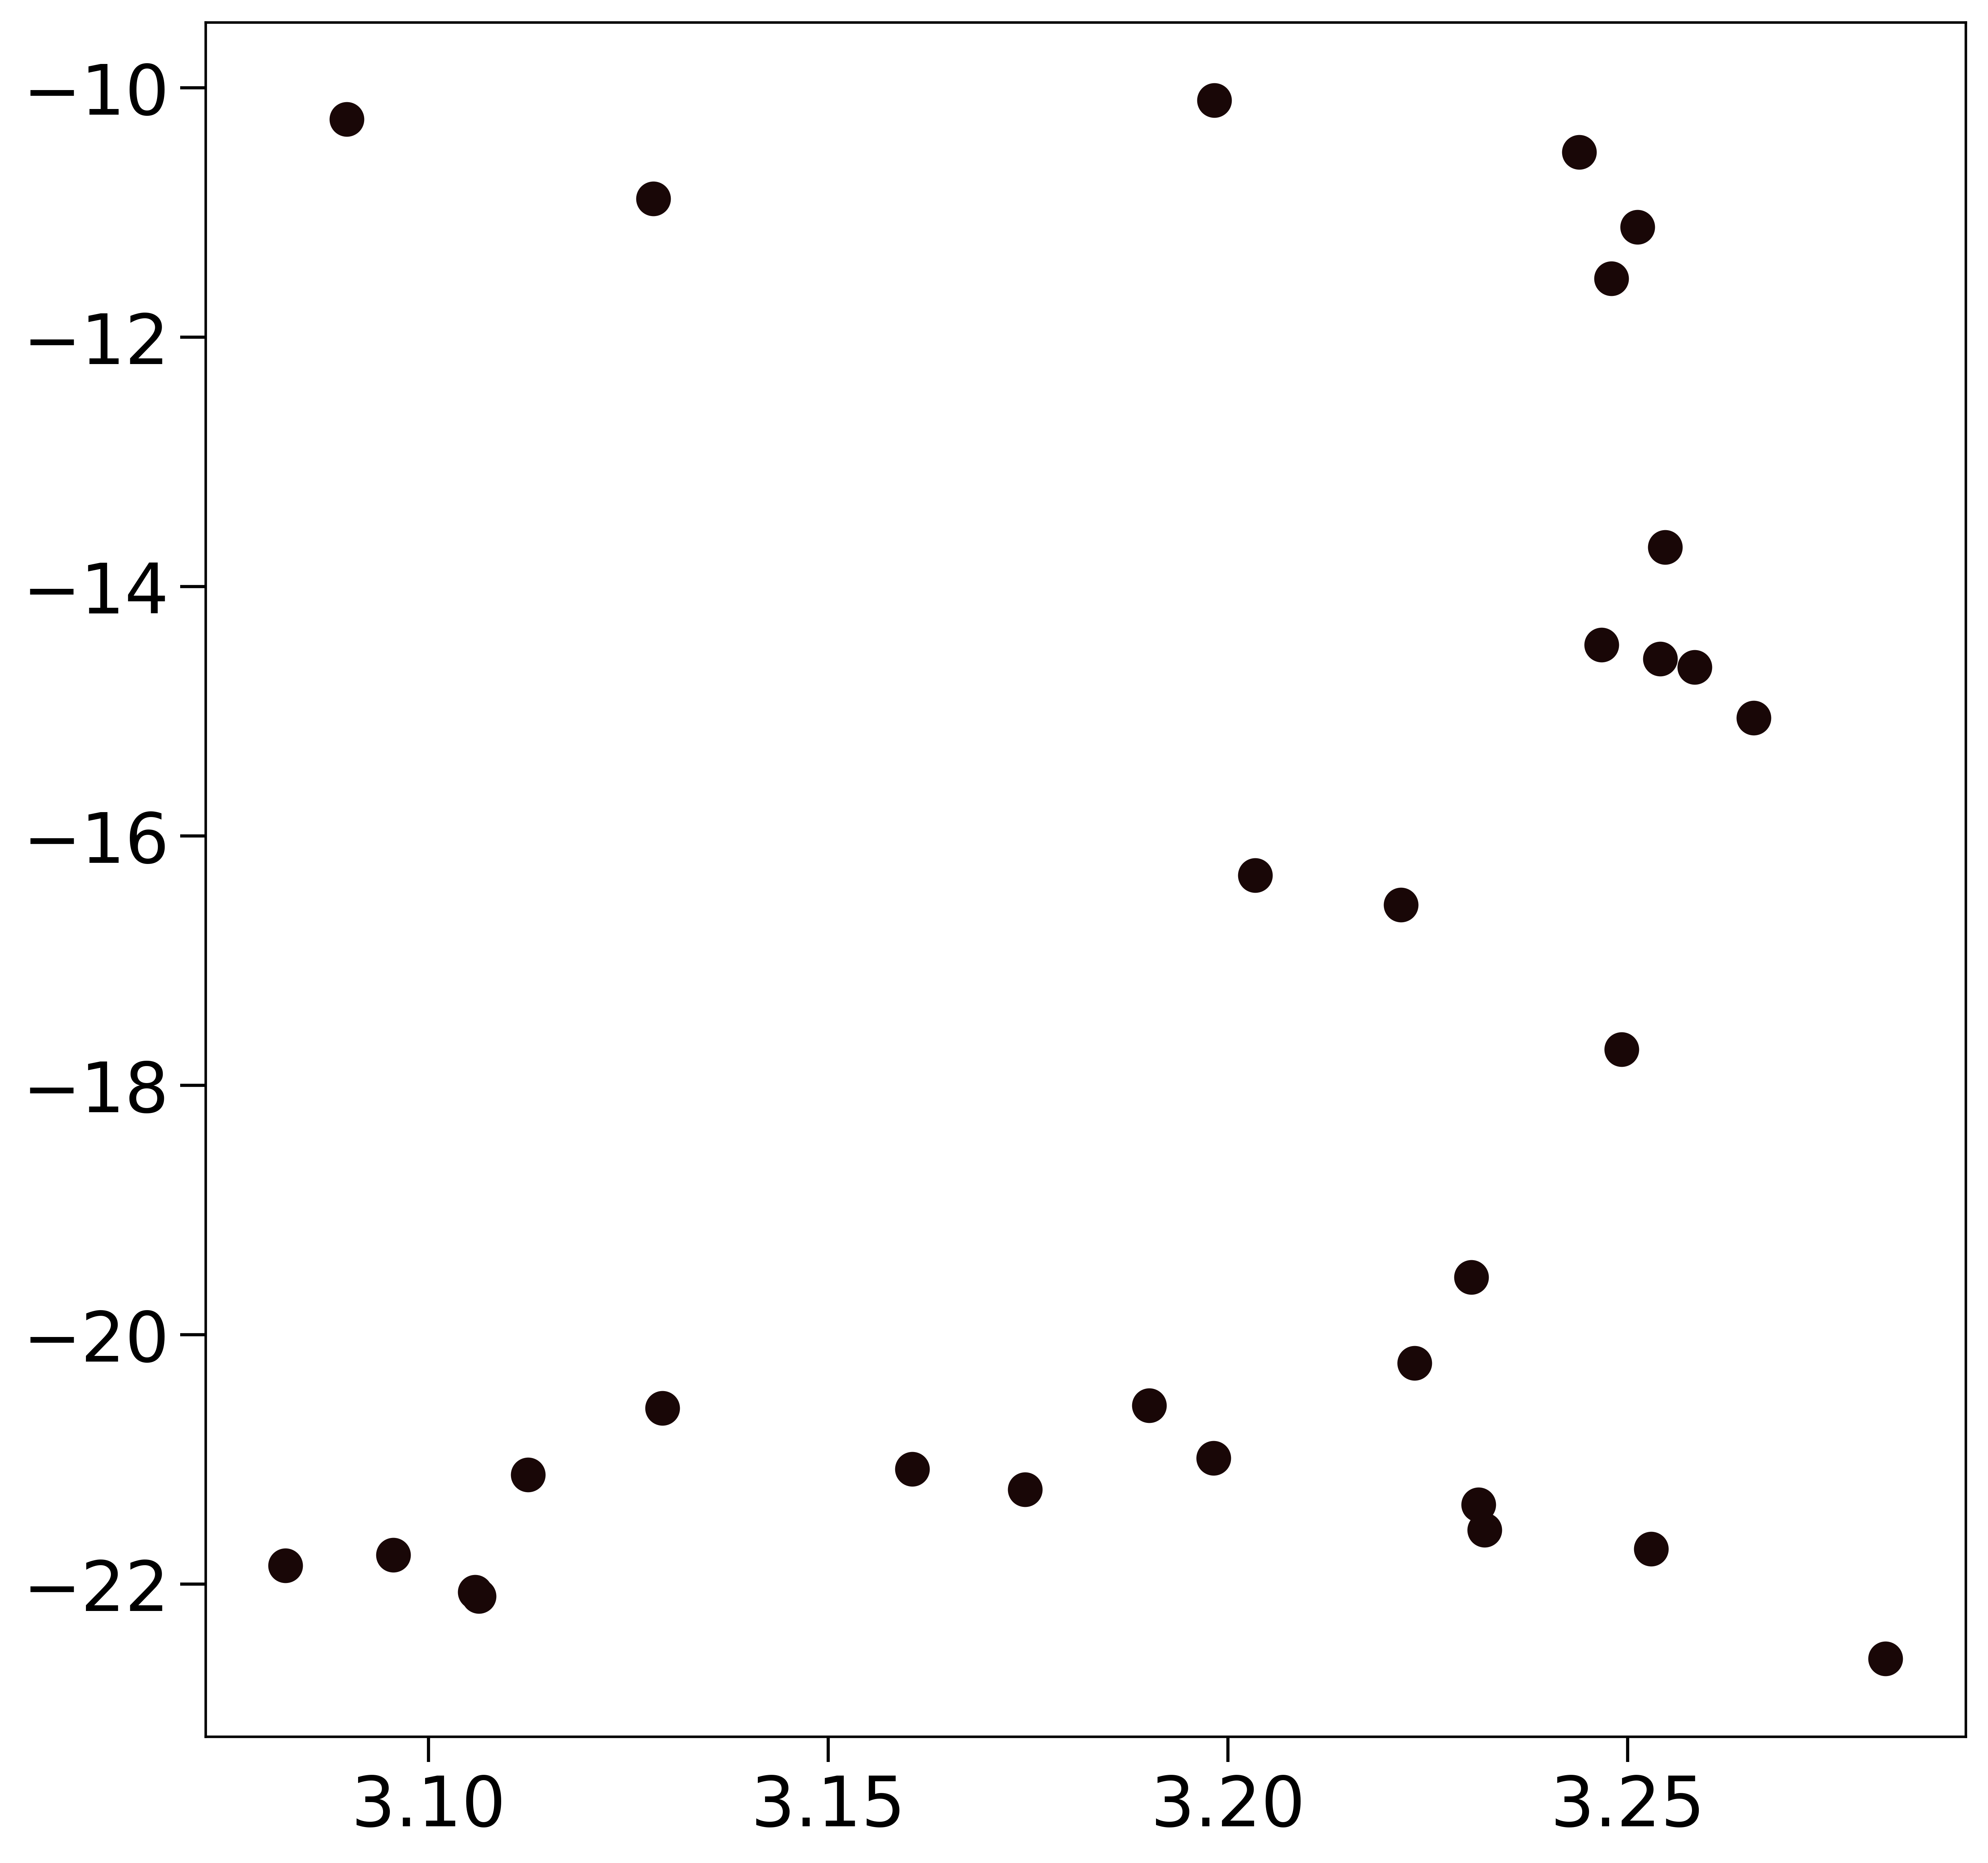

In [11]:
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,10])

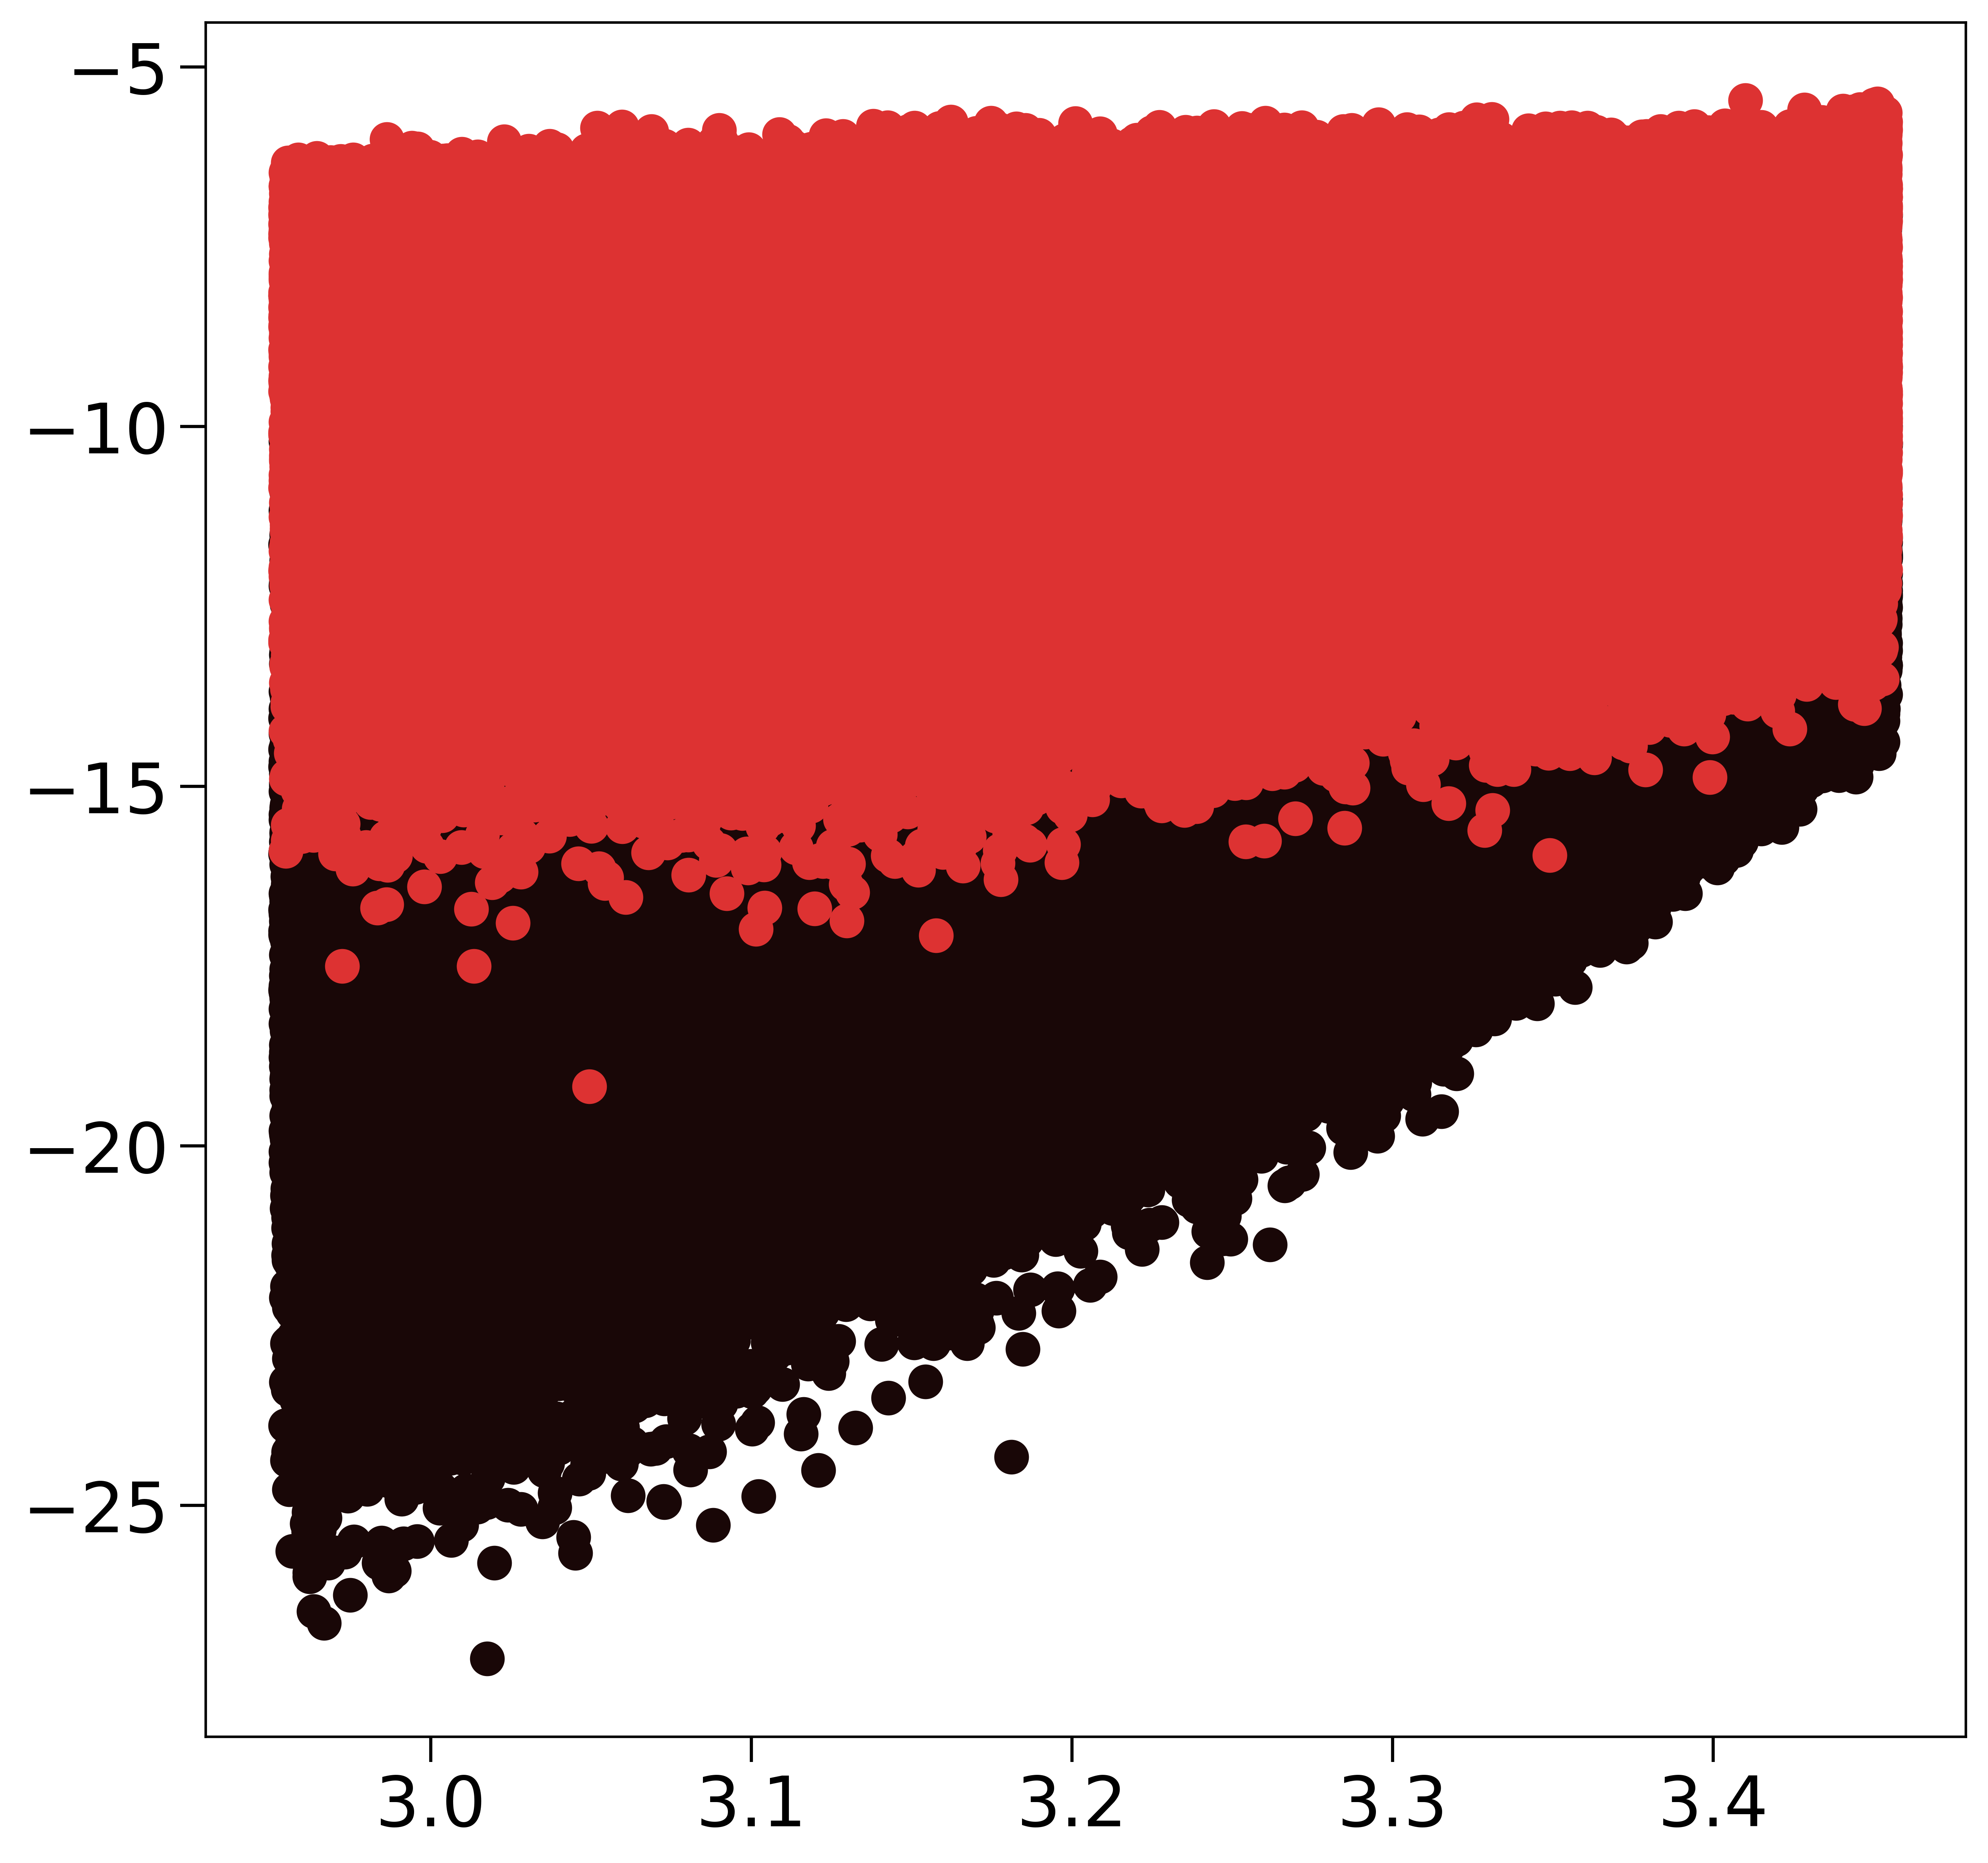

In [12]:
plt.scatter(Data['T0'][kmeans.labels_==0], Data['N'][kmeans.labels_==0])
plt.scatter(Data['T0'][kmeans.labels_==1], Data['N'][kmeans.labels_==1])

## Splitting Data and Writing Database 

In [15]:
from sklearn.model_selection import train_test_split

try:
    os.makedirs(OutputDir+'/Orig/train/')
except:
    pass
try:
    os.makedirs(OutputDir+'/Orig/valid/')
except:
    pass

In [16]:
data_id    = 'pts'

DataNoZero           = Data[kmeans.labels_ == 0]
n_points             = len(DataNoZero)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=valid_perc/100, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)

try:
    os.makedirs(OutputDir+'/Orig/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/Orig/valid/'+data_id+'/')
except:
    pass

DataInput  = DataNoZero[InputVar]
DataInput.iloc[train_idx].to_csv(OutputDir+'/Orig/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/Orig/valid/'+data_id+'/Input.csv', index=False)

DataOutput = DataNoZero[Vars]
DataOutput.iloc[train_idx].to_csv(OutputDir+'/Orig/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/Orig/valid/'+data_id+'/Output.csv', index=False)